
|       | Ile 1 | Ile 2 | Ile 3 | Ile 4 |
|-------|-------|-------|-------|-------|
| **Ile 1** | 0     | 0.3   | 0.3   | 0.4   |
| **Ile 2** | 0.3   | 0     | 0.4   | 0.3   |
| **Ile 3** | 0.3   | 0.4   | 0     | 0.3   |
| **Ile 4** | 0.4   | 0.3   | 0.3   | 0     |

Fichier CSV sauvegardé avec colonnes [generation, fitness, nb_evals] : csv/modele en île.csv


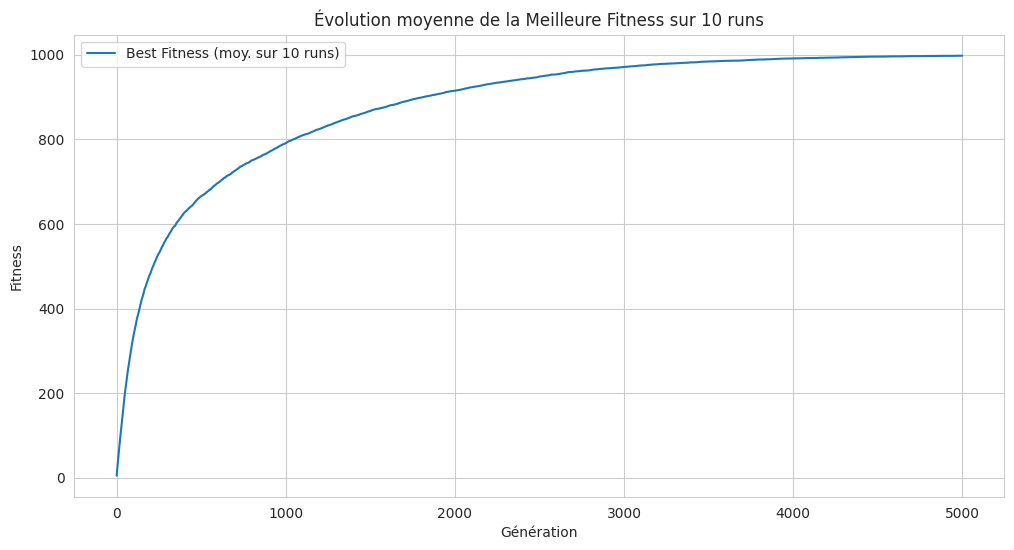

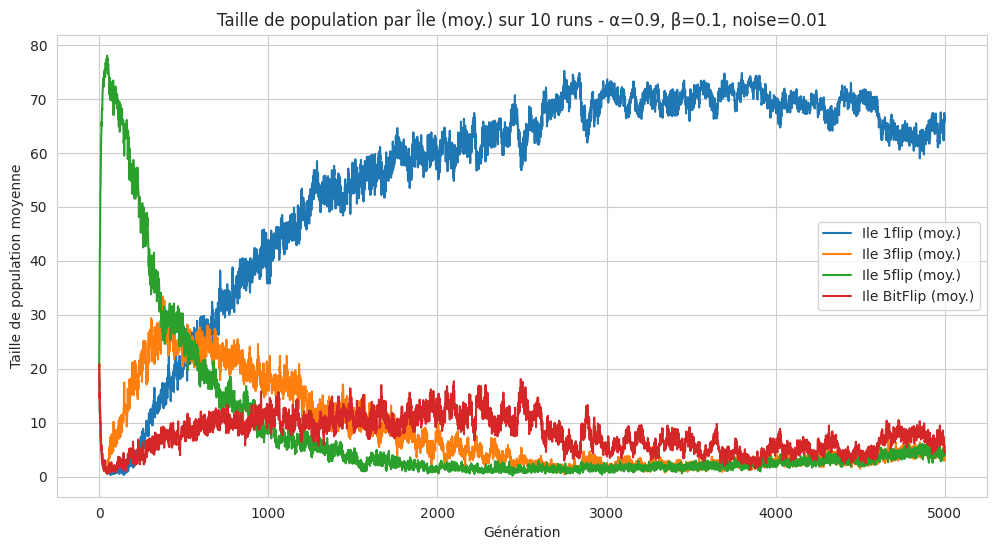

In [1]:
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import numpy as np
import pandas as pd

# Définition des constantes globales
TAILLE_VECTEUR = 1000
TAILLE_POPULATION = 20
MAX_ITER = 5000
N = 4  # Nombre d'îles
NB_RUNS = 10  # On répète l'expérience X fois

# ------------------------------------------------------------
# Opérateurs de mutation
# ------------------------------------------------------------
def mutation1flip(bits):
    """Mutation qui inverse un seul bit aléatoire."""
    child = bits[:]
    idx = random.randint(0, TAILLE_VECTEUR - 1)
    child[idx] = 1 - child[idx]
    return child

def mutation3flip(bits):
    """Mutation qui inverse trois bits aléatoires distincts."""
    child = bits[:]
    indices = random.sample(range(TAILLE_VECTEUR), 3)
    for idx in indices:
        child[idx] = 1 - child[idx]
    return child

def mutation5flip(bits):
    """Mutation qui inverse cinq bits aléatoires distincts."""
    child = bits[:]
    indices = random.sample(range(TAILLE_VECTEUR), 5)
    for idx in indices:
        child[idx] = 1 - child[idx]
    return child

def mutationBitFlip(bits):
    """Mutation qui inverse chaque bit avec une probabilité de 1/TAILLE_VECTEUR."""
    child = bits[:]
    for i in range(TAILLE_VECTEUR):
        if random.random() < 1 / TAILLE_VECTEUR:
            child[i] = 1 - child[i]
    return child

# ------------------------------------------------------------
# Classes de base
# ------------------------------------------------------------
class Individu:
    def __init__(self):
        # Initialisation de bits à 0
        self.bits = [0 for _ in range(TAILLE_VECTEUR)]
        self.origin = None
        self.currentIsland = None
        self.upgrade = 0
        self.migrated = False

    def getFitness(self):
        return sum(self.bits)

class Island:
    def __init__(self, id_island, operator, name):
        self.id = id_island
        self.population = [Individu() for _ in range(TAILLE_POPULATION)]
        self.operator = operator  # fonction de mutation
        self.name = name
        
    def getBestElement(self):
        if not self.population:
            return None
        return max(self.population, key=lambda x: x.getFitness())
    
    def getBestFitness(self):
        best = self.getBestElement()
        if best:
            return best.getFitness()
        return 0
    
    def local_search(self, archipelo):
        """
        Local Search simple : on applique la mutation sur chaque individu.
        Si l'enfant est meilleur, on remplace le parent.
        On met à jour l'upgrade de chaque individu.

        IMPORTANT:
        - On incrémente archipelo.nb_evals à chaque enfant évalué (child_fitness).
        """
        for ind in self.population:
            fitness_before = ind.getFitness()
            child_bits = self.operator(ind.bits)
            child_fitness = sum(child_bits)
            # On a évalué un nouvel individu => incrémenter nb_evals
            archipelo.nb_evals += 1
            
            if child_fitness > fitness_before:
                ind.bits = child_bits
            ind.upgrade = ind.getFitness() - fitness_before

class Archipelo:
    def __init__(self):
        self.islands = [
            Island(0, mutation1flip, "Ile 1flip"),
            Island(1, mutation3flip, "Ile 3flip"),
            Island(2, mutation5flip, "Ile 5flip"),
            Island(3, mutationBitFlip, "Ile BitFlip")
        ]
        # Matrice de migration : initialisée uniformément
        self.migrationMatrix = [[1.0/N for _ in range(N)] for _ in range(N)]
        # Matrice de récompense : mise à jour après chaque génération
        self.rewardMatrix = [[0.0 for _ in range(N)] for _ in range(N)]
        
        self.bestFitness = 0
        self.bestIndividual = None

        # Paramètres d'apprentissage / bruit
        self.alpha = 0.9
        self.beta = 0.1
        self.noise = 0.01

        # NOUVEAU: compteur global d'évaluations
        self.nb_evals = 0

    def getBestElement(self):
        best_elements = []
        for island in self.islands:
            best = island.getBestElement()
            if best is not None:
                best_elements.append(best)
        if not best_elements:
            return None
        return max(best_elements, key=lambda x: x.getFitness())
    
    def getBestFitness(self):
        best_element = self.getBestElement()
        if best_element:
            return best_element.getFitness()
        return 0
    
    def run_one_generation(self):
        """
        1) Migration
        2) Local search
        3) MàJ bestFitness
        4) Calcul Reward
        5) MàJ matrice de migration
        """
        # 1) MIGRATION
        for source_island in self.islands:
            probabilities = self.migrationMatrix[source_island.id]
            for ind in source_island.population[:]:  # copie pour itération
                if not ind.migrated:
                    rand = random.random()
                    destination = None
                    cumulative_prob = 0.0
                    for i, proba in enumerate(probabilities):
                        cumulative_prob += proba
                        if rand < cumulative_prob:
                            destination = i
                            break
                    if destination is None:
                        destination = random.randrange(N)
                    
                    ind.origin = source_island.id
                    ind.currentIsland = destination
                    ind.migrated = True
                    
                    source_island.population.remove(ind)
                    self.islands[destination].population.append(ind)

        # On réinitialise le flag migrated
        for island in self.islands:
            for ind in island.population:
                ind.migrated = False

        # 2) LOCAL SEARCH
        for island in self.islands:
            island.local_search(self)

        # 3) MàJ bestFitness
        current_best = self.getBestFitness()
        if current_best > self.bestFitness:
            self.bestFitness = current_best
            self.bestIndividual = self.getBestElement()

        # 4) Calcul Reward
        num_islands = len(self.islands)
        self.rewardMatrix = [[0.0 for _ in range(num_islands)] for _ in range(num_islands)]
        
        migrants_by_origin_dest = defaultdict(list)
        for island in self.islands:
            for ind in island.population:
                if ind.origin is not None:
                    migrants_by_origin_dest[(ind.origin, ind.currentIsland)].append(ind)
        
        for i_source in range(num_islands):
            dest_improvements = {}
            for i_dest in range(num_islands):
                key = (i_source, i_dest)
                if key in migrants_by_origin_dest:
                    inds = migrants_by_origin_dest[key]
                    if inds:
                        mean_up = sum(i.upgrade for i in inds) / len(inds)
                        dest_improvements[i_dest] = mean_up
                    else:
                        dest_improvements[i_dest] = 0.0
                else:
                    dest_improvements[i_dest] = 0.0
            
            best_value = max(dest_improvements.values())
            best_destinations = [d for d, v in dest_improvements.items() if v == best_value and best_value > 0]
            if best_value > 0:
                reward_per_best = 1.0 / len(best_destinations)
                for bd in best_destinations:
                    self.rewardMatrix[i_source][bd] = reward_per_best
        
        # 5) MàJ matrice de migration
        for i in range(num_islands):
            for j in range(num_islands):
                old_ij = self.migrationMatrix[i][j]
                r_ij = self.rewardMatrix[i][j]
                
                new_ij = (1 - self.beta) * (self.alpha * old_ij + (1 - self.alpha) * r_ij) \
                         + self.beta * self.noise
                self.migrationMatrix[i][j] = new_ij
        
        # Normalisation
        for i in range(num_islands):
            row_sum = sum(self.migrationMatrix[i])
            if row_sum > 0:
                for j in range(num_islands):
                    self.migrationMatrix[i][j] /= row_sum
            else:
                # Ligne anormale, on répartit uniformément
                for j in range(num_islands):
                    self.migrationMatrix[i][j] = 1.0 / num_islands

def run_experiment():
    """
    Lance UNE exécution complète (jusqu'à MAX_ITER ou jusqu'à la solution).
    Retourne :
      - best_fitness_history : liste des meilleures fitness par génération (longueur MAX_ITER)
      - population_history   : {nom_ile: [taille_pop_à_chaque_génération]}
      - nb_evals_history     : liste du nb_evals après chaque génération
      - archipelo            : l'objet final
    """
    archipelo = Archipelo()
    
    # Initialisation manuelle : origin et currentIsland
    for island in archipelo.islands:
        for ind in island.population:
            ind.currentIsland = island.id
            ind.origin = island.id
    
    # Pour le suivi
    population_history = {island.name: [] for island in archipelo.islands}
    best_fitness_history = []
    nb_evals_history = []

    for generation in range(MAX_ITER):
        if archipelo.bestFitness == TAILLE_VECTEUR:
            break

        archipelo.run_one_generation()
        
        # Sauvegarder la best_fitness
        best_fitness_history.append(archipelo.bestFitness)
        
        # Sauvegarder le nb_evals ACTUEL
        nb_evals_history.append(archipelo.nb_evals)
        
        # Sauvegarder la taille des populations
        for island in archipelo.islands:
            population_history[island.name].append(len(island.population))
        
        # Arrêt si OneMax optimum atteint
        if archipelo.bestFitness == TAILLE_VECTEUR:
            # on complète le reste des itérations (jusqu'à MAX_ITER-1)
            # par la même valeur, pour garder la même longueur
            for _ in range(generation+1, MAX_ITER):
                best_fitness_history.append(archipelo.bestFitness)
                nb_evals_history.append(archipelo.nb_evals)
                for island in archipelo.islands:
                    population_history[island.name].append(len(island.population))
            break
    
    return best_fitness_history, population_history, nb_evals_history, archipelo

def save_data_to_csv(fitness_histories, evals_histories, filename="modele en île.csv", folder="csv"):
    """
    Sauvegarde dans un CSV trois colonnes: generation, fitness, nb_evals,
    en prenant la MOYENNE sur tous les runs pour chaque génération.

    Paramètres
    ----------
    fitness_histories : numpy array (NB_RUNS, MAX_ITER)
        best_fitness_history pour chaque run, aligné sur les générations.
    evals_histories : numpy array (NB_RUNS, MAX_ITER)
        nb_evals_history pour chaque run, aligné sur les générations.
    filename : str
        Nom du fichier CSV (par défaut "Archipelo.csvArchipelo.csv")
    folder : str
        Nom du dossier où sauvegarder.
    """
    # 1) Moyennes
    mean_fitness = np.mean(fitness_histories, axis=0)   # shape (MAX_ITER,)
    mean_evals = np.mean(evals_histories, axis=0)       # shape (MAX_ITER,)

    # 2) DataFrame
    data = {
        "generation": list(range(len(mean_fitness))),
        "fitness": mean_fitness,
        "nb_evals": mean_evals
    }
    df = pd.DataFrame(data)

    # 3) Créer le dossier s'il n'existe pas
    if not os.path.exists(folder):
        os.makedirs(folder)

    # 4) Sauvegarde CSV
    filepath = os.path.join(folder, filename)
    df.to_csv(filepath, index=False)
    print(f"Fichier CSV sauvegardé avec colonnes [generation, fitness, nb_evals] : {filepath}")

def main():
    all_fitness_runs = []
    all_population_runs = []
    all_evals_runs = []
    
    for run_index in range(NB_RUNS):
        bf_history, pop_history, nb_evals_history, archipelo = run_experiment()
        all_fitness_runs.append(bf_history)
        all_population_runs.append(pop_history)
        all_evals_runs.append(nb_evals_history)
    
    # Convertir en numpy array => shape (NB_RUNS, MAX_ITER)
    all_fitness_runs_array = np.array(all_fitness_runs)
    all_evals_runs_array = np.array(all_evals_runs)
    
    # Sauvegarder en CSV (moyenne sur NB_RUNS)
    save_data_to_csv(
        fitness_histories=all_fitness_runs_array,
        evals_histories=all_evals_runs_array,
        filename="modele en île.csv",
        folder="csv"
    )

    #
    # -- En plus, on peut tracer l'évolution moyenne comme avant --
    #
    # 1) Moyenne Best Fitness
    avg_best_fitness = np.mean(all_fitness_runs_array, axis=0)  # shape (MAX_ITER,)
    # 2) Moyenne nb_evals
    avg_nb_evals = np.mean(all_evals_runs_array, axis=0)        # shape (MAX_ITER,)

    # 3) Population moyenne
    #   (On peut procéder comme auparavant pour calculer population moyenne par île.)
    island_names = list(all_population_runs[0].keys())
    avg_populations = {name: [0.0]*MAX_ITER for name in island_names}
    for name in island_names:
        for gen in range(MAX_ITER):
            s = 0.0
            for r in range(NB_RUNS):
                s += all_population_runs[r][name][gen]
            avg_populations[name][gen] = s / NB_RUNS

    # => Plot 1: Best Fitness vs. Generation
    plt.figure(figsize=(12, 6))
    plt.plot(avg_best_fitness, label=f"Best Fitness (moy. sur {NB_RUNS} runs)")
    plt.xlabel("Génération")
    plt.ylabel("Fitness")
    plt.title(f"Évolution moyenne de la Meilleure Fitness sur {NB_RUNS} runs")
    plt.legend()
    plt.grid(True)
    plt.show()

    # => Plot 2: Best Fitness vs. nb_evals
    #    (Optionnel: un scatter ou line, reliant points (avg_nb_evals, avg_best_fitness).)
    # plt.figure(figsize=(12, 6))
    # plt.plot(avg_nb_evals, avg_best_fitness, 'o-', label="Best Fitness vs nb_evals")
    # plt.xlabel("Nombre moyen d'évaluations")
    # plt.ylabel("Fitness")
    # plt.title(f"Évolution de la Fitness par rapport au nb_evals (moy. sur {NB_RUNS} runs)")
    # plt.grid(True)
    # plt.legend()
    # plt.show()

    # => Plot 3: Population size per Island
    plt.figure(figsize=(12, 6))
    for name in island_names:
        plt.plot(avg_populations[name], label=f"{name} (moy.)")
    plt.xlabel('Génération')
    plt.ylabel('Taille de population moyenne')
    plt.title('Taille de population par Île (moy.) sur ' + str(NB_RUNS) + ' runs'
              + f" - α={archipelo.alpha}, β={archipelo.beta}, noise={archipelo.noise}")
    plt.legend()
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    main()
